In [34]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos, save_embeds_with_wts
import numpy as np
import pandas as pd

## Data Prep

Reading in experimental data to see which words to run the model on

In [39]:
db = access_db()
results, incl_users = get_results_elig_users(db, 'Self Consistency', 0.2)

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [10]:
test_repeat_lem_cnt = get_lemma_counts(results, incl_users, db)
test_words = test_repeat_lem_cnt[test_repeat_lem_cnt['num_trials'] > 10]['lemma']

## Modeling

In [12]:
model_data = {}
test_stats = []
incorrect = []
for w in test_words:
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [69]:
model_perf = pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

## Analysis of Classifier Performance

In [70]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['word'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
with_entropy = model_perf.merge(semcor_entropy, on = 'word')

Text(0.5, 1.0, 'Entropy and Average F1 Score')

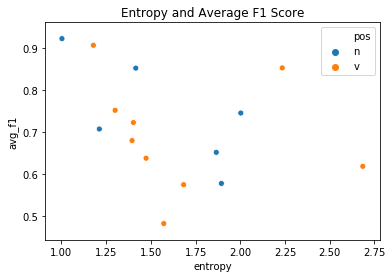

In [75]:
sns.scatterplot(x = 'entropy', y = 'avg_f1', hue = 'pos', data = with_entropy)
plt.title("Entropy and Average F1 Score")

In [77]:
model_perf['num_senses'] = model_perf['word'].apply(get_num_senses, args = [db])
model_perf['pos'] = model_perf['word'].apply(get_pos, args = ['_'])


Text(0.5, 1, 'Number of Senses and Average F1 Score')

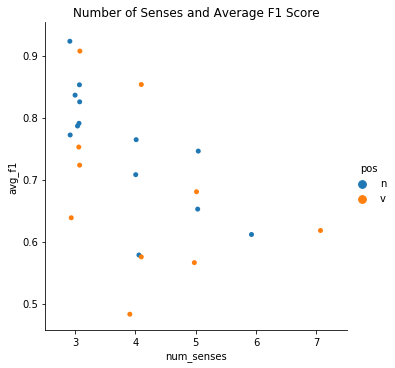

In [93]:
sns.catplot(x = 'num_senses', y = 'avg_f1', hue = 'pos', data = model_perf)
plt.title("Number of Senses and Average F1 Score")

## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [14]:
import seaborn as sns

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


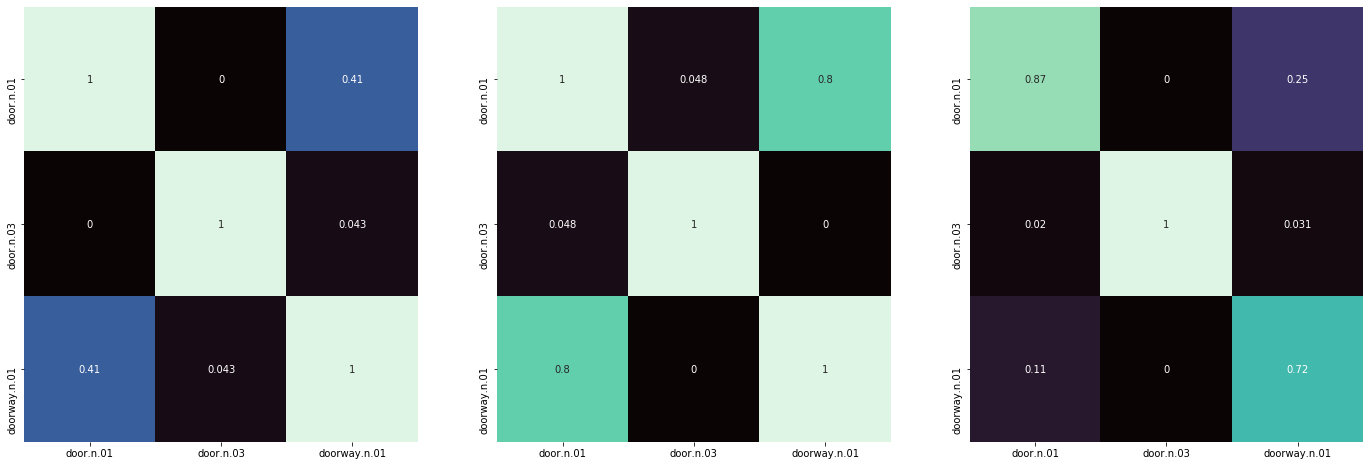

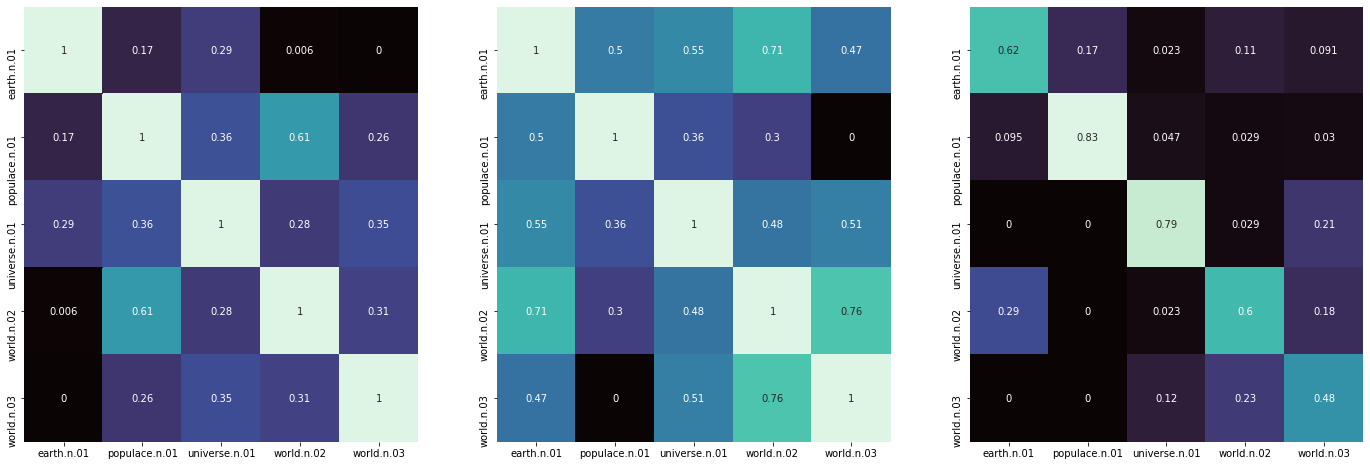

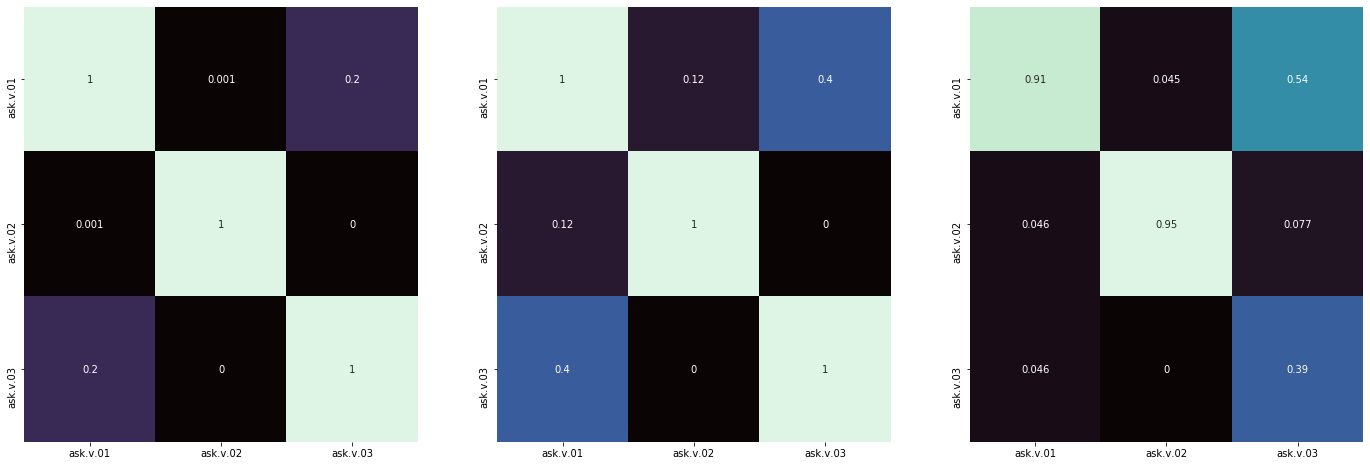

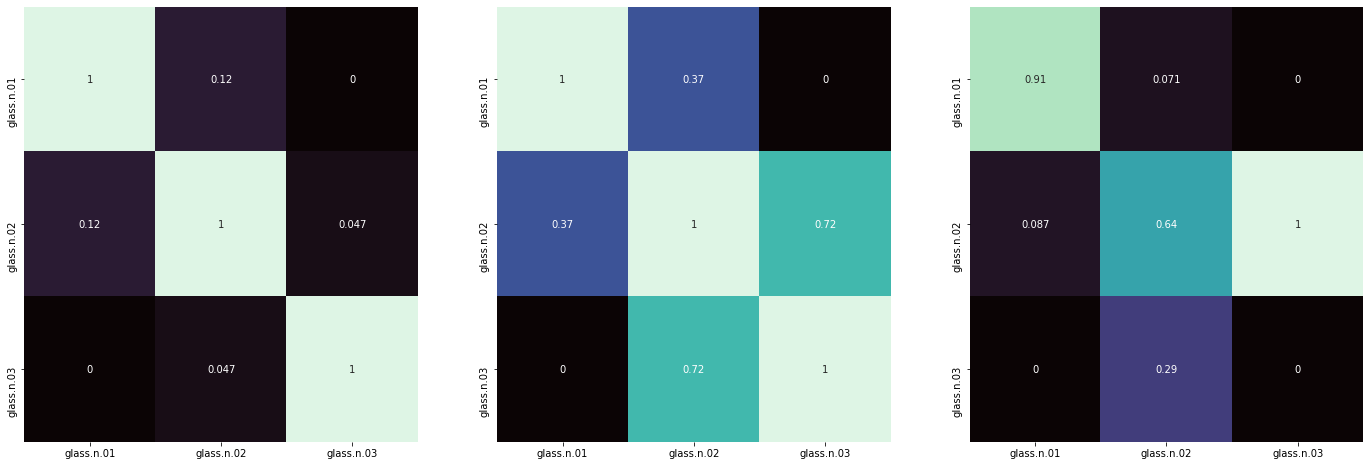

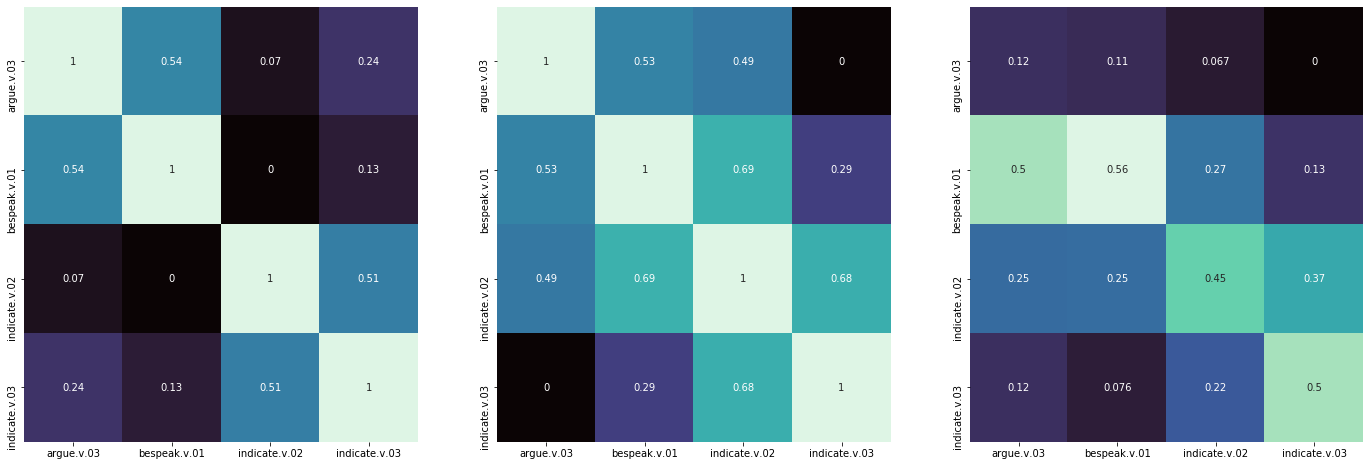

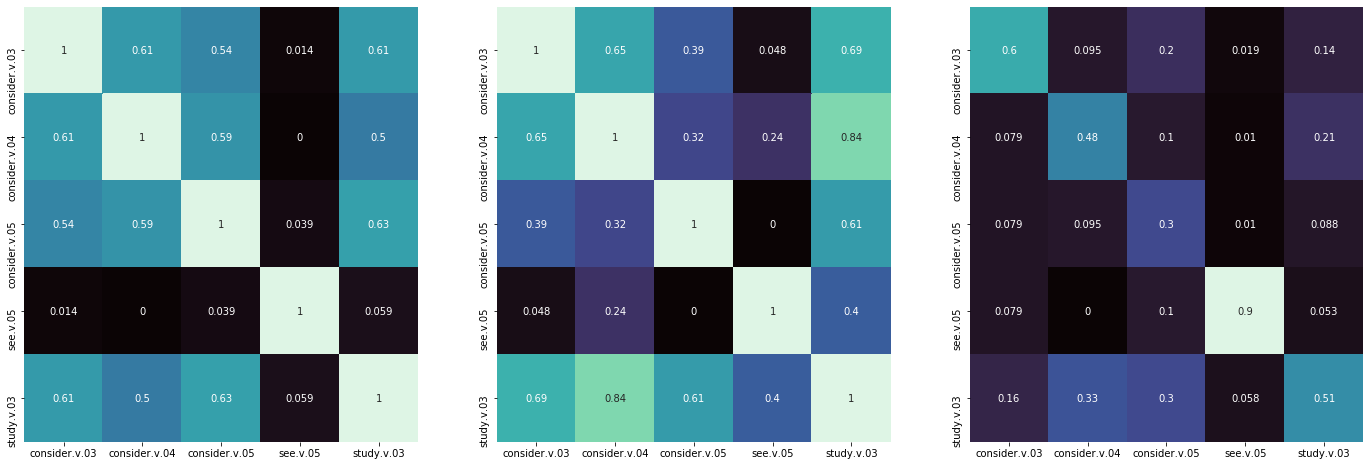

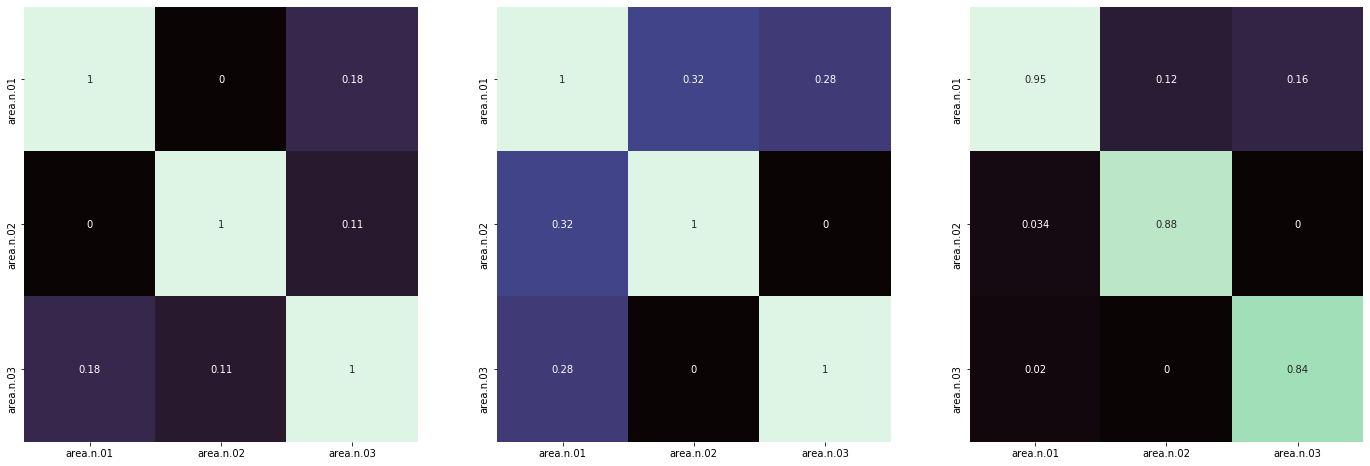

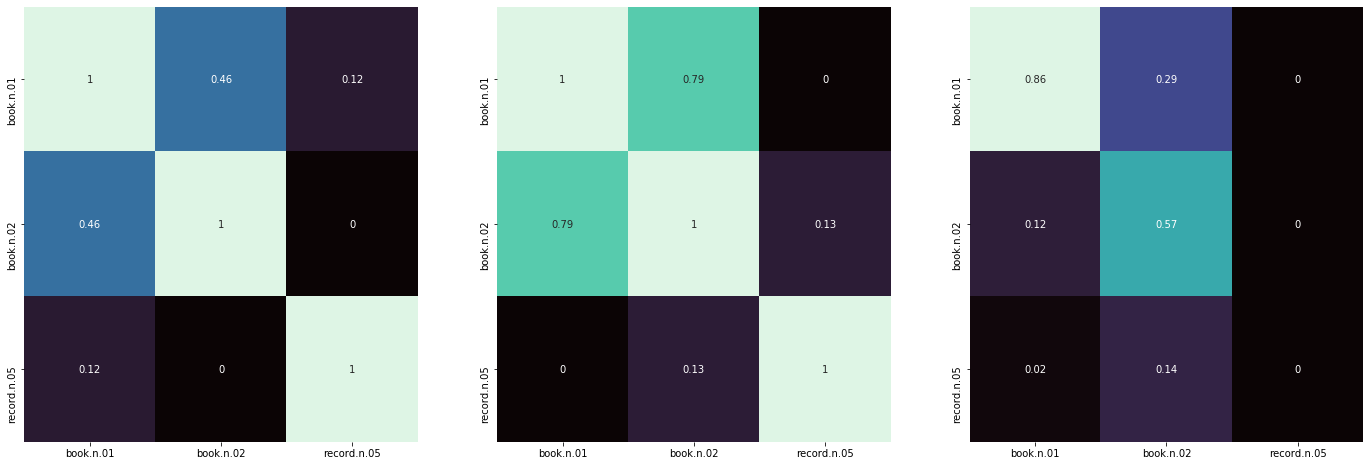

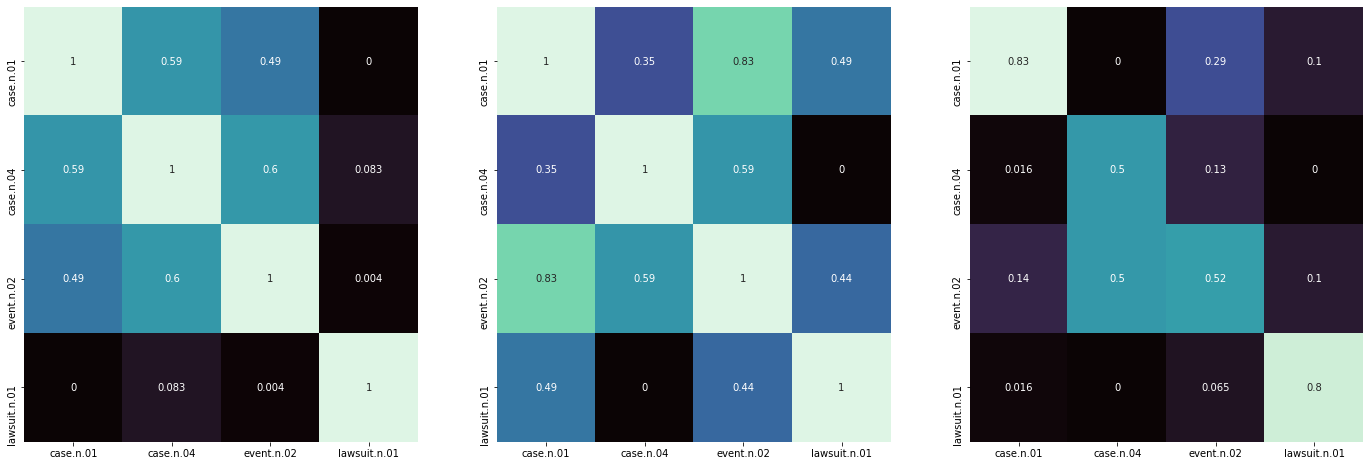

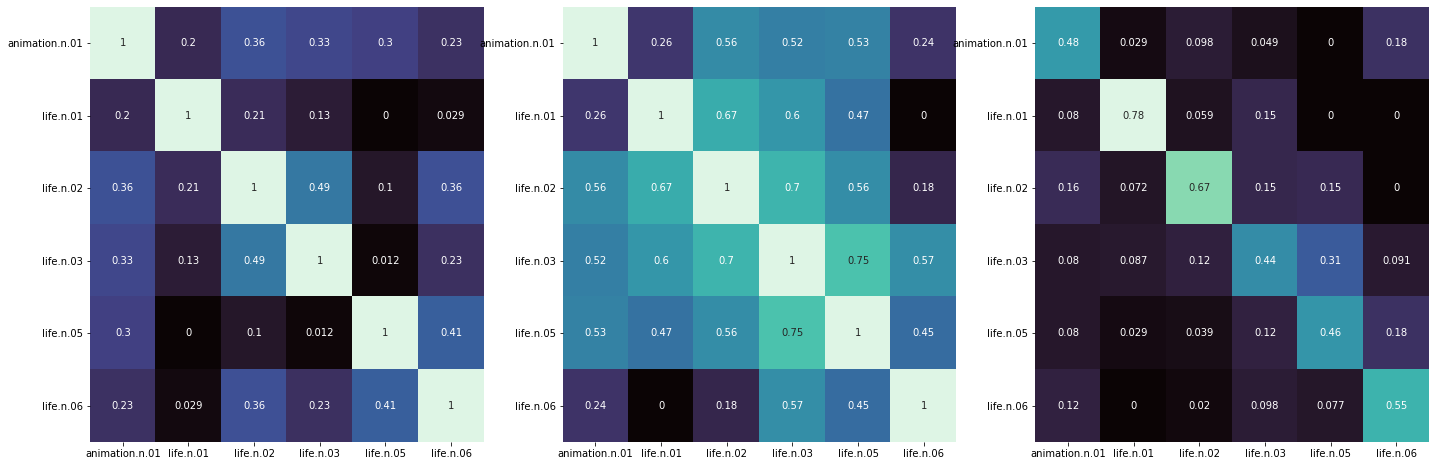

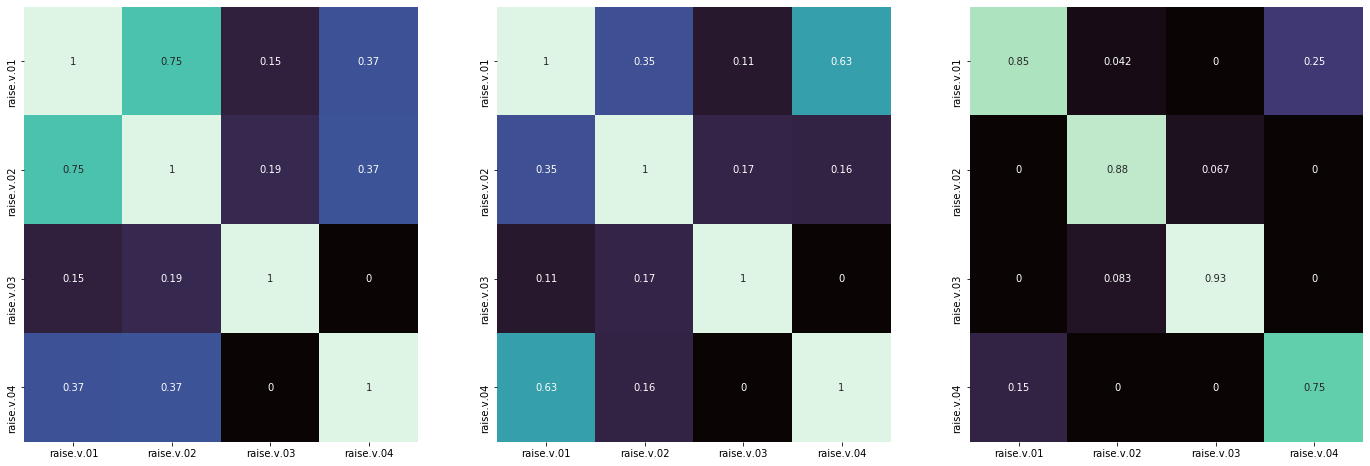

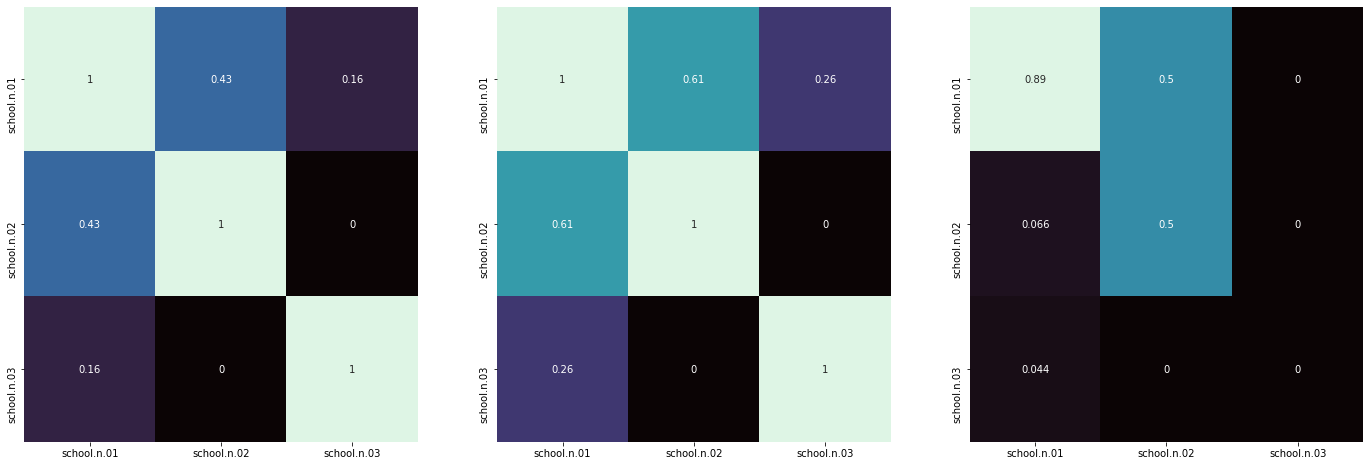

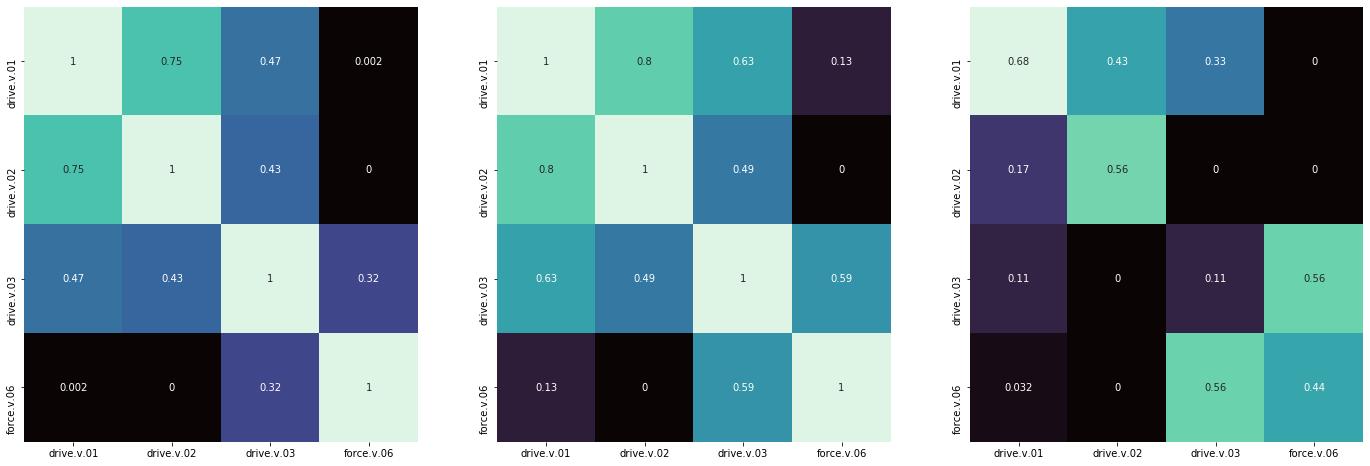

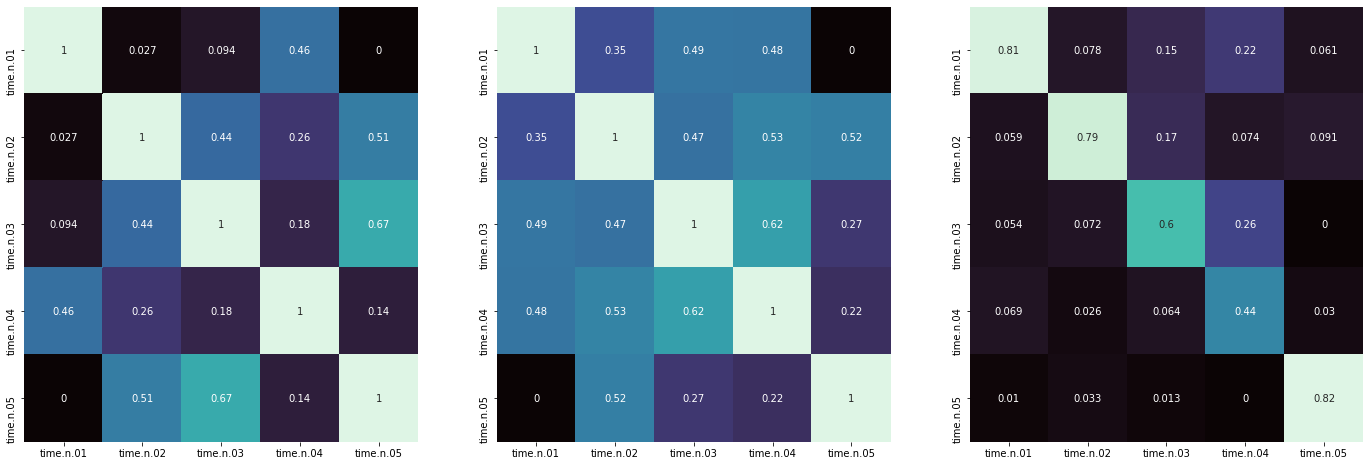

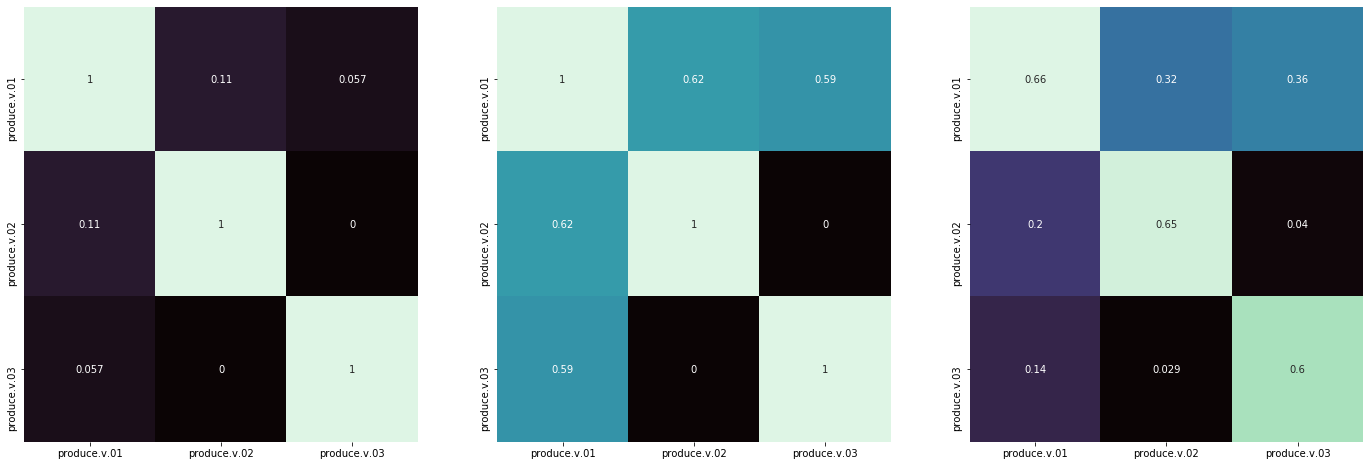

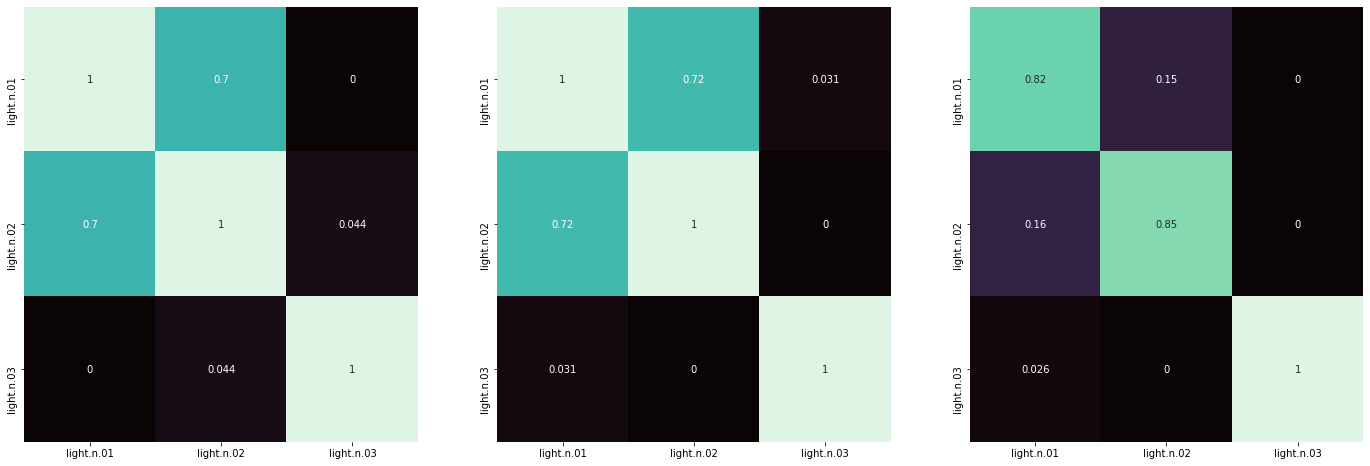

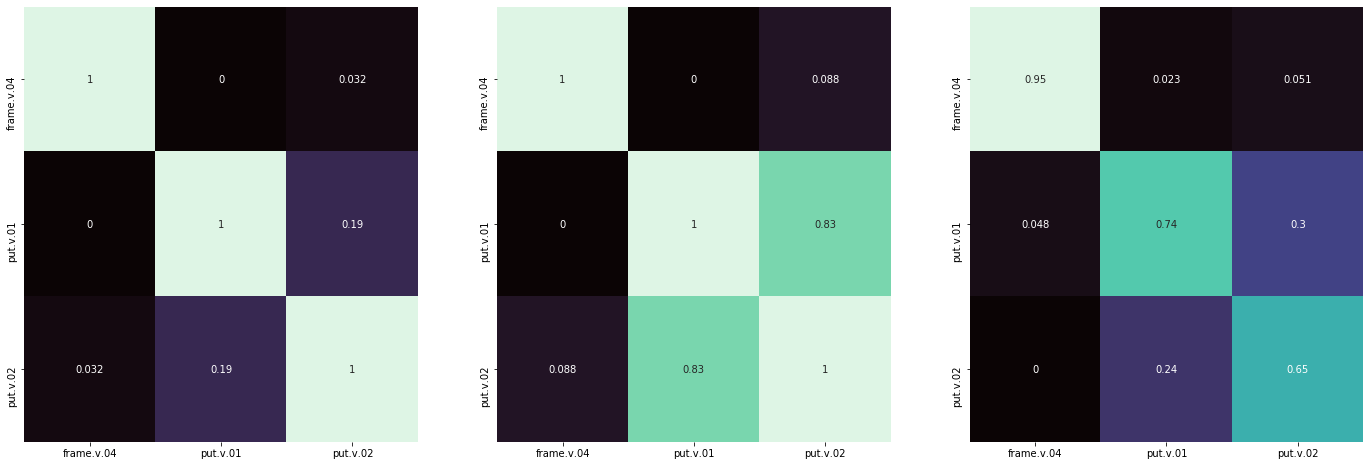

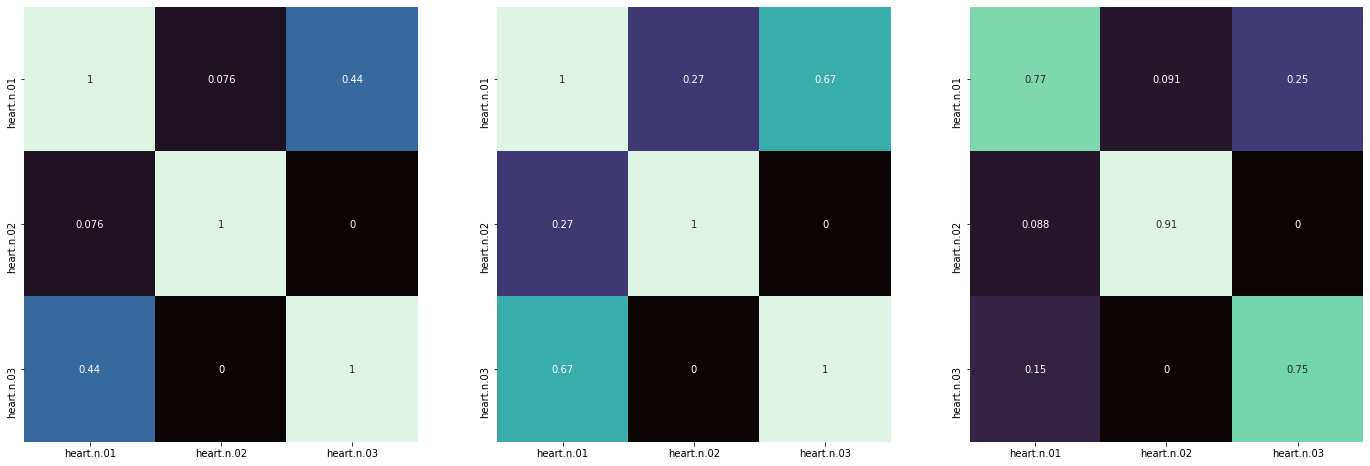

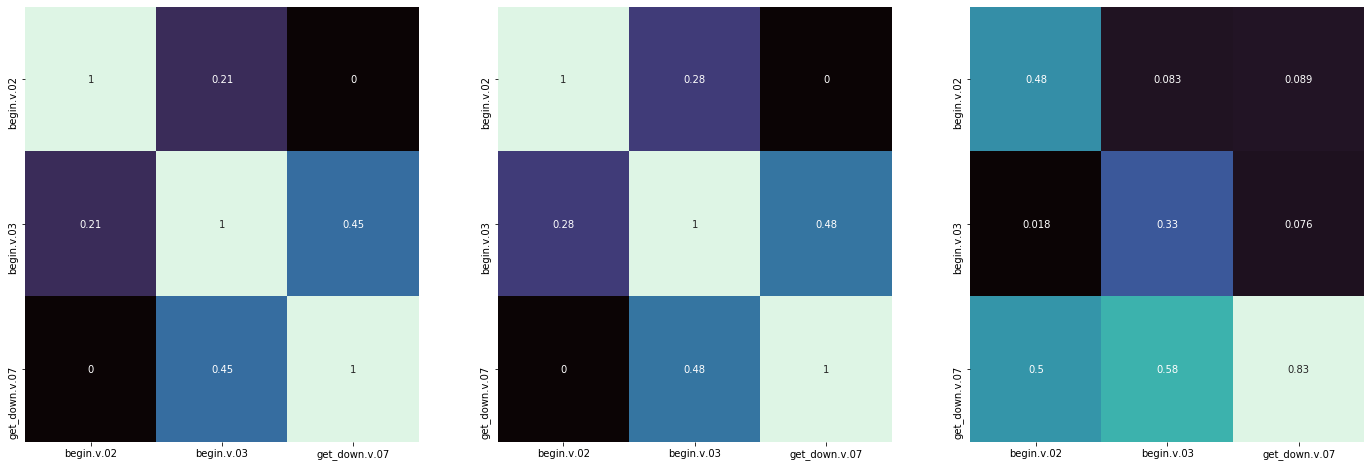

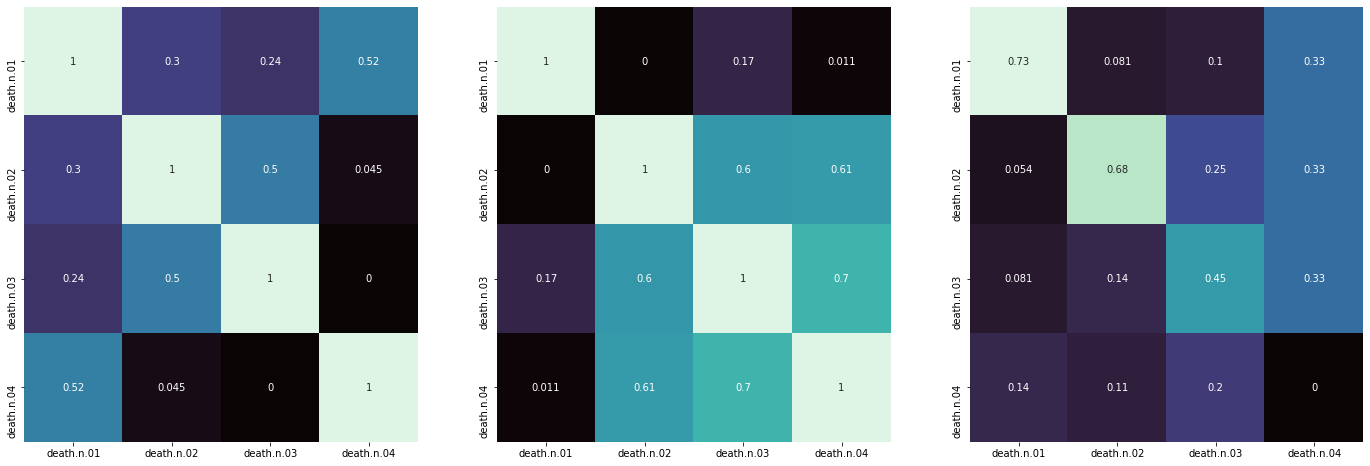

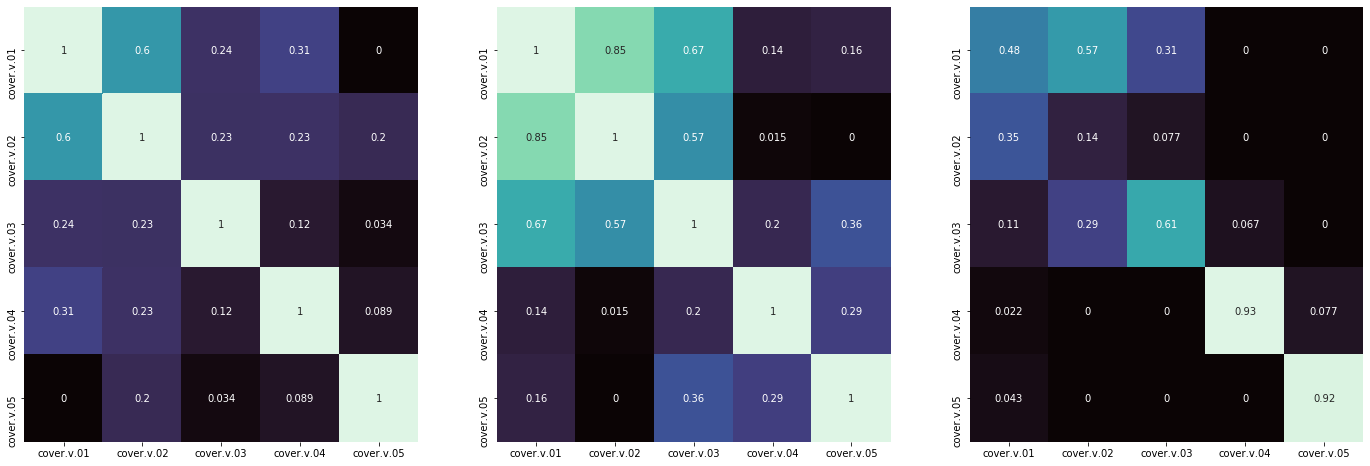

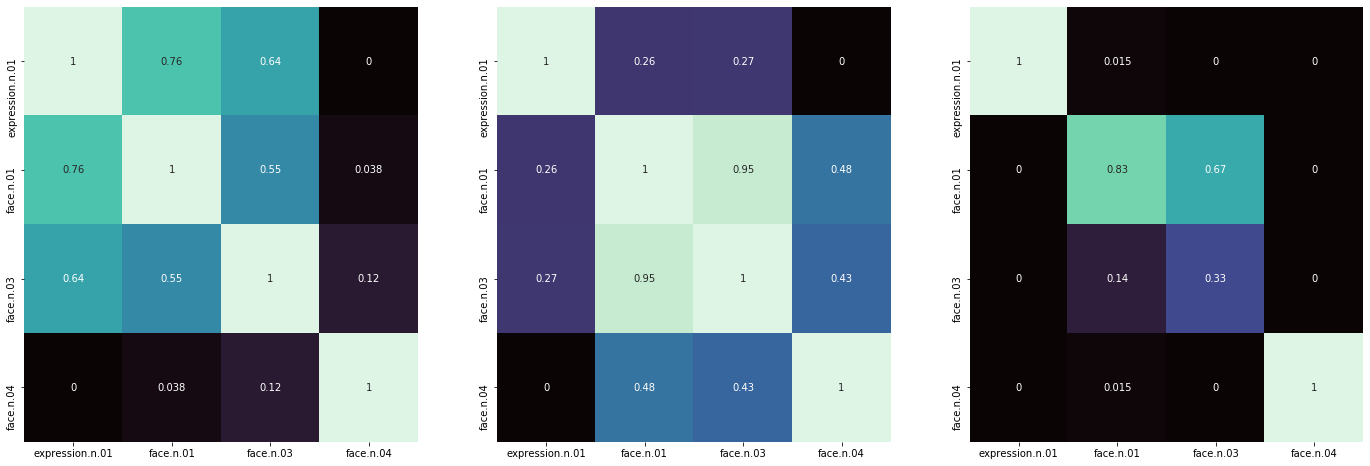

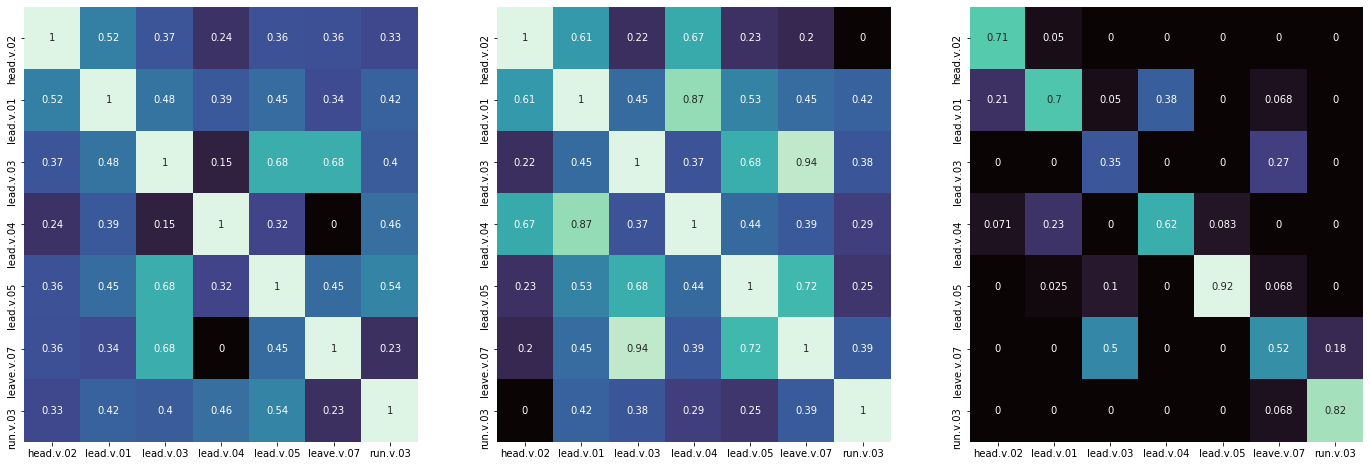

In [17]:
matrices = {w: {} for w in test_words}

with PdfPages('../../results/similarities.pdf') as pdf_pages:
    for w in test_words:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))

        avg_reported = get_test_result_data(results, w, incl_users)
        matrices[w]['expt'] = avg_reported
        senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
        expt_fig = sns.heatmap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True,
                               cbar = False, ax = ax1)
        #reordered_sense_indices = cg.dendrogram_row.reordered_ind
        
        word, pos = w.split("_")
        bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                             corpus = 'semcor', use_masc = False)
        bert_cs = normalize_cos_dist(bert_cs)
        matrices[w]['bert'] = bert_cs
        bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses), ax = ax2, annot = True, cmap = 'mako', cbar = False)

        word_matrices = model_data[w]['confusion_matrices']
        agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
        agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
        conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses), cmap = 'mako', ax = ax3, annot = True,
                               cbar = False)
        pdf_pages.savefig(fig)

## Comparison of Embeddings with Nonzero Weights to Experimental Data

Saving values at nonzero weights

In [18]:
from core.semcor_bert_pipeline import save_embeds_with_wts

We print the percent of weights that are nonzero for the embeddings of each type

In [ ]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))

In [19]:
shared_words = ['table_n', 'foot_n', 'plane_n', 'right_n', 'model_n', 'degree_n']
for w in shared_words:
    matrices[w] = {}
    matrices[w]['expt'] = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))],
                                         corpus = 'select_weights', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs


For all test words (r for full embeddings was 0.43)

In [20]:
all_words = test_words.tolist() + shared_words

In [21]:
all_human_avg = [matrices[w]['expt'] for w in all_words]
all_bert_cs = [matrices[w]['bert'] for w in all_words]
bert_human_test = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_test

0.478447242017759

Text(0.5, 0, "Pearson's R")

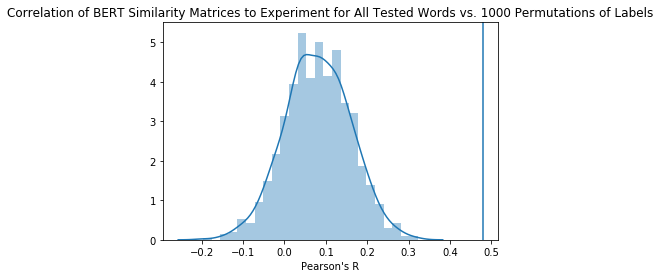

In [22]:
permuted_bert_entries = [mtx_correlation(all_bert_cs, all_human_avg,
                                         method = 'pearson', randomize_m1_labels = True) for i in range(1000)]
sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_test)
plt.title("Correlation of BERT Similarity Matrices to Experiment for All Tested Words vs. 1000 Permutations of Labels")
plt.xlabel("Pearson's R")

In [23]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(semcor_bert_pipeline.get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(all_words) & (results['userID'].isin(incl_users))]

Full embeddings for nouns r = 0.33, verbs r = 0.59

In [24]:
containing_query(all_trials, 'pos', ['n'], matrices)

0.40294796540000516

In [25]:
containing_query(all_trials, 'pos', ['v'], matrices)

0.5721980869227536

Text(0.5, 1.0, 'Correlation between BERT and Averaged Experimental Data vs. Number of Senses')

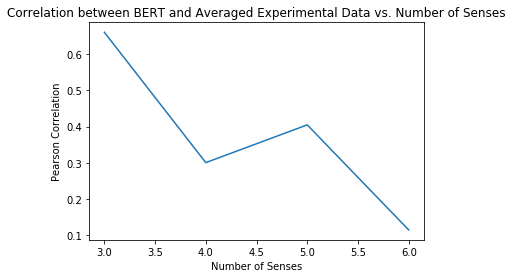

In [26]:
plt.plot(range(3, 7), [containing_query(all_trials, 'num_senses', [i], matrices) for i in range(3, 7)])
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.title("Correlation between BERT and Averaged Experimental Data vs. Number of Senses")

In [27]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

High entropy r = 0.17, Low/Medium entropy = 0.68

In [28]:
range_query(all_entropy, 'entropy', 1.45, 2.5, matrices)

0.17994587524737302

In [29]:
range_query(all_entropy, 'entropy', 0, 1.45, matrices)

0.7076455090523335